In [131]:
dataset_folder_name = 'UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [132]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            # return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
            return int(age)
        except Exception as ex:
            # return None, None, None
            return None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'file']
    df = df.dropna()
    
    return df

In [134]:
df = parse_dataset(dataset_folder_name)
df.head(100)

,age,file
0,100.0,UTKFace\100_0_0_20170112213500903.jpg
1,100.0,UTKFace\100_0_0_20170112215240346.jpg
2,100.0,UTKFace\100_1_0_20170110183726390.jpg
3,100.0,UTKFace\100_1_0_20170112213001988.jpg
4,100.0,UTKFace\100_1_0_20170112213303693.jpg
...,...,...
95,10.0,UTKFace\10_0_2_20161219190639572.jpg
96,10.0,UTKFace\10_0_2_20170110224230094.jpg
97,10.0,UTKFace\10_0_2_20170116162109013.jpg
98,10.0,UTKFace\10_0_3_20161220215952636.jpg


In [135]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [136]:
# bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
# names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

# age_binned = pd.cut(df['age'], bins, labels=names)
# plt.plot_distribution(age_binned)

In [137]:
# from keras.utils import to_categorical
# from PIL import Image
import cv2

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        # self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        # self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        # im = Image.open(img_path)
        # im = im.resize((IM_WIDTH, IM_HEIGHT))
        # im = np.array(im) / 255.0
        im = cv2.imread(img_path)
        im = cv2.resize(im, (IM_WIDTH, IM_HEIGHT))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        # images, ages, races, genders = [], [], [], []
        images, ages = [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                # race = person['race_id']
                # gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                # races.append(to_categorical(race, len(dataset_dict['race_id'])))
                # genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # return np.array(images), np.array(ages)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), np.array(ages)
                    images, ages = [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()
len(train_idx), len(valid_idx), len(test_idx)

(11811, 5062, 7232)

In [138]:
from keras.models import Model
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

In [145]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    device=physical_devices[0], enable=True)

RuntimeError: Physical devices cannot be modified after being initialized

In [139]:
class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 1)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)

In [140]:
# from tensorflow.keras import models, optimizers, regularizers
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.models import save_model

# def VGG16(width, height, weight_decay = 0, dropout_rate = 0.5):
#     model = models.Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(
#         width, height, 3), kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
#                      kernel_regularizer=regularizers.l2(weight_decay)))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Flatten())  # 2*2*512
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='softmax'))

#     return model
# model = VGG16(IM_WIDTH, IM_HEIGHT)

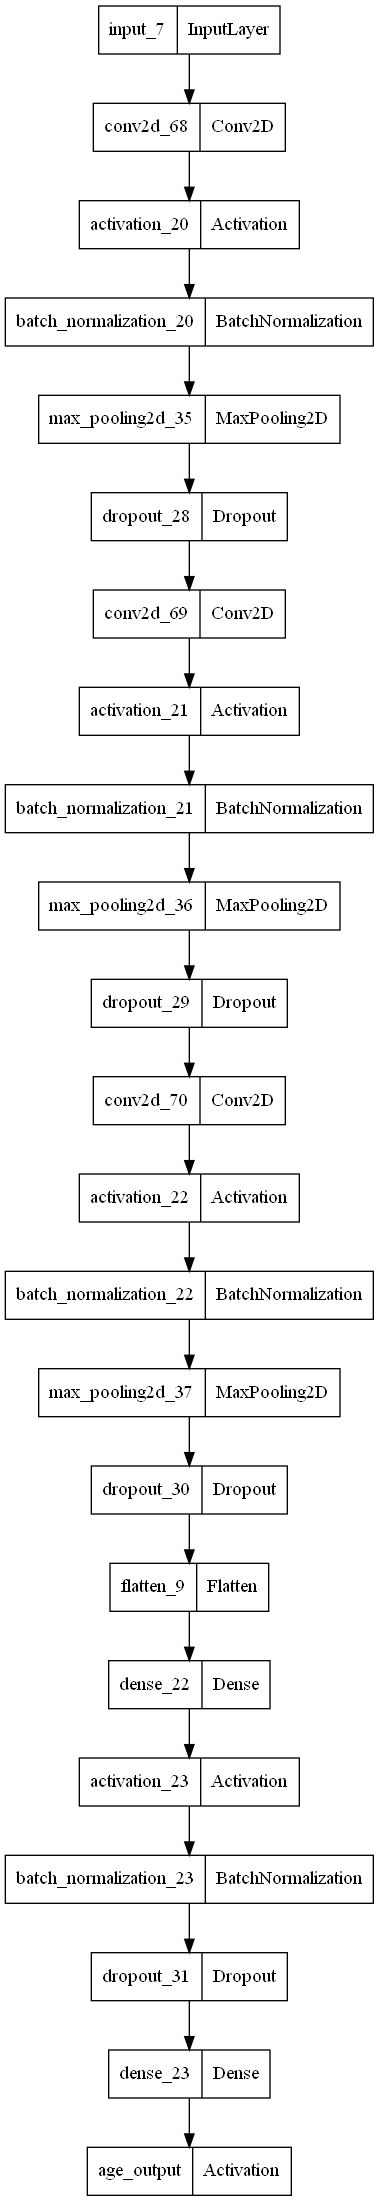

In [141]:
%matplotlib inline

# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
# img = mpimg.imread('model.png')

# plt.figure(figsize=(40, 30))
# plt.imshow(img)

In [142]:
model.summary()

Model: "face_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 198, 198, 1)]     0         
                                                                 
 conv2d_68 (Conv2D)          (None, 198, 198, 16)      160       
                                                                 
 activation_20 (Activation)  (None, 198, 198, 16)      0         
                                                                 
 batch_normalization_20 (Bat  (None, 198, 198, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 66, 66, 16)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 66, 66, 16)        0  

In [143]:
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse'},
              loss_weights={
                  'age_output': 4.},
              metrics={
                  'age_output': ['mae']})
# model.compile(optimizer=opt, 
#               loss='mse',
#               loss_weights= 4.,
#               metrics='mae')

In [144]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

model.save('age-01-01.h5')

Epoch 1/100
113/369 [========>.....................] - ETA: 6:43 - loss: 12.0035 - mae: 1.3722

KeyboardInterrupt: 